### Load Data

Using TensorFlow backend.


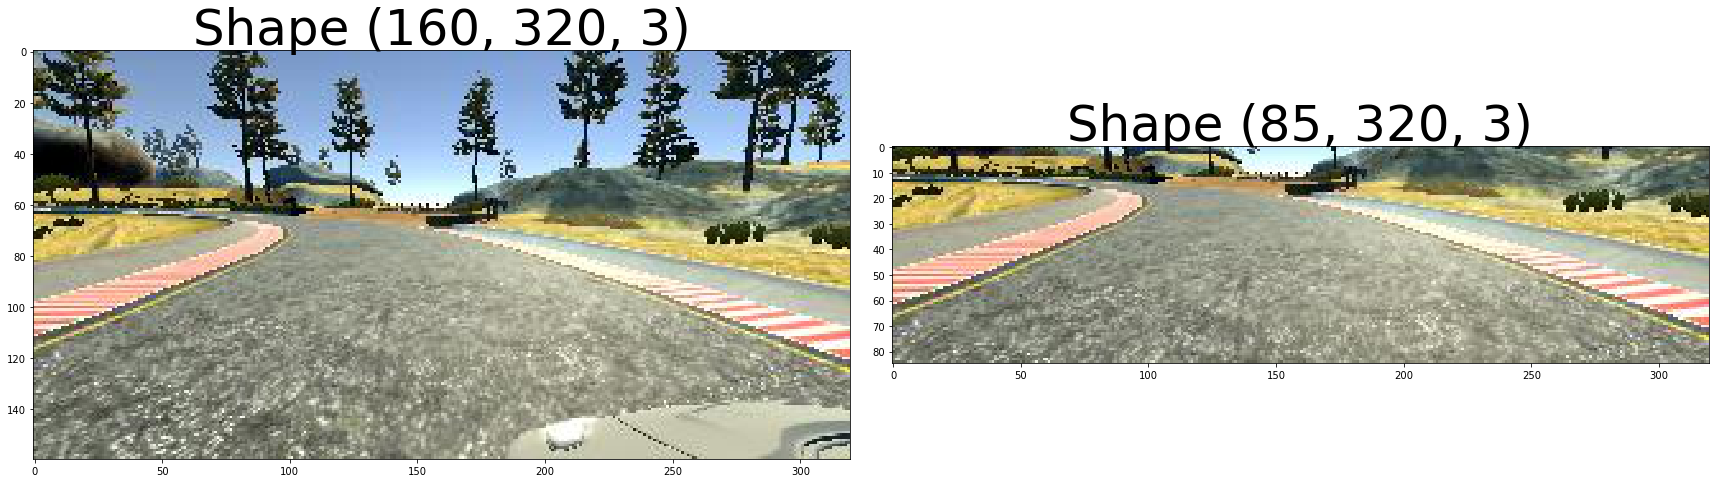

Orig std: 59.0443961231
Norm std: 49.9937
Orig mean: 143.700071615
Norm mean: 148.247


In [1]:
import csv
import cv2
import random
import sklearn
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras import backend as ktf
from sklearn.model_selection import train_test_split
%matplotlib inline

correction = 0.2
samples = []
with open('./data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append((line[0].split('/')[-1], float(line[3])))
        samples.append((line[1].split('/')[-1], float(line[3])+correction))
        samples.append((line[2].split('/')[-1], float(line[3])-correction))
    
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def read_sample(sample):
    image = cv2.cvtColor(cv2.imread('./data/IMG/' + sample[0]), cv2.COLOR_BGR2RGB)
    angle = float(sample[1])
    return image, angle

def compare_images(left_image, right_image):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_image)
    ax1.set_title('Shape '+ str(left_image.shape), fontsize=50)
    ax2.imshow(np.uint8(right_image))
    ax2.set_title('Shape '+ str(right_image.shape), fontsize=50)
    plt.show()
    
    print('Orig std:', np.std(left_image))
    print('Norm std:', np.std(right_image))
    print('Orig mean:', np.mean(left_image))
    print('Norm mean:', np.mean(right_image))
    
image, angle = read_sample(train_samples[0])

model = Sequential()
model.add(Cropping2D(cropping=((50,25),(0,0)), input_shape=(160,320,3)))

new_img = model.predict(image[np.newaxis,...])
new_img = new_img.reshape(new_img.shape[1:])
                    
compare_images(image, new_img)

In [5]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image = cv2.cvtColor(cv2.imread('./data/IMG/' + batch_sample[0]), cv2.COLOR_BGR2RGB)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

batch_size = 256
train_generator = generator(train_samples, batch_size = batch_size)
validation_generator = generator(validation_samples, batch_size = batch_size)

### Build and Train Model

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/batch_size, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/batch_size, 
                    epochs=10)

model.save('model1.h5')

Epoch 1/10
34/33 [==============================] - 22s - loss: 2.2963 - val_loss: 0.0454
Epoch 2/10
34/33 [==============================] - 22s - loss: 0.0466 - val_loss: 0.0391
Epoch 3/10
34/33 [==============================] - 22s - loss: 0.0421 - val_loss: 0.0386
Epoch 4/10
34/33 [==============================] - 22s - loss: 0.0411 - val_loss: 0.0380
Epoch 5/10
34/33 [==============================] - 22s - loss: 0.0400 - val_loss: 0.0374
Epoch 6/10
34/33 [==============================] - 22s - loss: 0.0391 - val_loss: 0.0366
Epoch 7/10
34/33 [==============================] - 22s - loss: 0.0377 - val_loss: 0.0354
Epoch 8/10
34/33 [==============================] - 22s - loss: 0.0367 - val_loss: 0.0336
Epoch 9/10
34/33 [==============================] - 22s - loss: 0.0352 - val_loss: 0.0317
Epoch 10/10
34/33 [==============================] - 22s - loss: 0.0344 - val_loss: 0.0306


In [6]:
from time import time
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K

with K.name_scope('setup'):
    model = Sequential()

with K.name_scope('net'):
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3), name='normalization'))
    model.add(Cropping2D(cropping=((50,20),(0,0)), name='cropping'))

    model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2), name='conv_1'))
    model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2), name='conv_2'))
    model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2), name='conv_3'))
    model.add(Conv2D(64, (3, 3), activation="relu", name='conv_4'))
    model.add(Conv2D(64, (3, 3), activation="relu", name='conv_5'))
    model.add(Flatten(name='flatten'))
    model.add(Dropout(0.5, name='dropout_1'))
    model.add(Dense(100, name='dense_1'))
    model.add(Dense(50, name='dense_2'))
    model.add(Dense(10, name='dense_3'))
    model.add(Dropout(0.5, name='dropout_2'))
    model.add(Dense(1, name='output'))

with K.name_scope('compile'):
    model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)

#early_stop = EarlyStopping(min_delta=0.001, patience=3)
tensorboard = TensorBoard(log_dir='graph/{}'.format(int(time())), 
                          histogram_freq=0, 
                          batch_size=batch_size, 
                          write_graph=True, 
                          write_images=True)
tensorboard.set_model(model)

model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/batch_size, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/batch_size, 
                    callbacks = [tensorboard],
                    epochs=5)

model.save('model.h5')

Epoch 1/5
34/33 [==============================] - 23s - loss: 0.0655 - val_loss: 0.0263
Epoch 2/5
34/33 [==============================] - 22s - loss: 0.0246 - val_loss: 0.0215
Epoch 3/5
34/33 [==============================] - 22s - loss: 0.0233 - val_loss: 0.0197
Epoch 4/5
34/33 [==============================] - 22s - loss: 0.0220 - val_loss: 0.0207
Epoch 5/5
34/33 [==============================] - 22s - loss: 0.0202 - val_loss: 0.0180


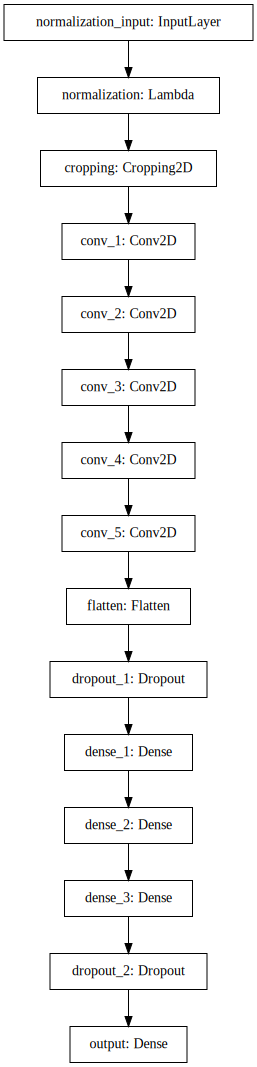

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))